<a href="https://colab.research.google.com/github/elvinaqa/Intent-Recognition-Flask-Deployment/blob/main/Intent_GRU_Model_90%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import files

# 2. Upload dataset

In [ ]:
files.upload()

Saving Dataset.csv to Dataset.csv


{'Dataset.csv': b'Need help pleese,commonQ.assist\r\nNeed help,commonQ.assist\r\nI need some info,commonQ.assist\r\nWill you help me?,commonQ.assist\r\nWhat else can you do?,commonQ.assist\r\nWhat do you do?,commonQ.assist\r\nWhat can you help me with?,commonQ.assist\r\nWhat can you do?,commonQ.assist\r\nWhat are you good at?,commonQ.assist\r\nNeed help plz,commonQ.assist\r\nHow can you help me,commonQ.assist\r\nCan you help me?,commonQ.assist\r\nHow can you assist?,commonQ.assist\r\nHow can you help me?,commonQ.assist\r\nHow do you help?,commonQ.assist\r\nHow to help you?,commonQ.assist\r\nHow will you assist me?,commonQ.assist\r\ni need help,commonQ.assist\r\nCan you tell some info,commonQ.assist\r\nHelp me please,commonQ.assist\r\nIs this a bot?,commonQ.bot\r\nIs there a bot chatting to me?,commonQ.bot\r\nIs it automated message?,commonQ.bot\r\nComputer based pely,commonQ.bot\r\nBot or human?,commonQ.bot\r\nBot is chatting with me?,commonQ.bot\r\nAre you system generated message?,co

In [ ]:
def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
  print(df.head())
  intent = df["Intent"]
  unique_intent = list(set(intent))
  sentences = list(df["Sentence"])
  
  return (intent, unique_intent, sentences)
  


In [ ]:
intent, unique_intent, sentences = load_dataset("Dataset.csv")

                Sentence          Intent
0       Need help pleese  commonQ.assist
1              Need help  commonQ.assist
2       I need some info  commonQ.assist
3      Will you help me?  commonQ.assist
4  What else can you do?  commonQ.assist


In [ ]:
intent

0       commonQ.assist
1       commonQ.assist
2       commonQ.assist
3       commonQ.assist
4       commonQ.assist
             ...      
1108    faq.borrow_use
1109    faq.borrow_use
1110    faq.borrow_use
1111    faq.borrow_use
1112    faq.borrow_use
Name: Intent, Length: 1113, dtype: object

In [ ]:
sentences

['Need help pleese',
 'Need help',
 'I need some info',
 'Will you help me?',
 'What else can you do?',
 'What do you do?',
 'What can you help me with?',
 'What can you do?',
 'What are you good at?',
 'Need help plz',
 'How can you help me',
 'Can you help me?',
 'How can you assist?',
 'How can you help me?',
 'How do you help?',
 'How to help you?',
 'How will you assist me?',
 'i need help',
 'Can you tell some info',
 'Help me please',
 'Is this a bot?',
 'Is there a bot chatting to me?',
 'Is it automated message?',
 'Computer based pely',
 'Bot or human?',
 'Bot is chatting with me?',
 'Are you system generated message?',
 'Are you robot?',
 'Are you machine?',
 'Are you just computer?',
 'Are you a robot?',
 'Are you a person?',
 'Are you a machine?',
 'Are you a chatbot?',
 'Are you a bot?',
 'Are these automated messages?',
 'Am I talking to a bot?',
 'You are a boy are girl?',
 'You are a bot or human?',
 'This is a machine?',
 'This is a chatbot?',
 'System generated reply

In [ ]:
print(sentences[:10])

['Need help pleese', 'Need help', 'I need some info', 'Will you help me?', 'What else can you do?', 'What do you do?', 'What can you help me with?', 'What can you do?', 'What are you good at?', 'Need help plz']


In [ ]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#define stemmer
stemmer = LancasterStemmer()

# 3. Data Cleaning

In [ ]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    #stemming
    words.append([i.lower() for i in w])
    
  return words  

In [ ]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  

1113
[['need', 'help', 'pleese'], ['need', 'help']]


### 3.1 Keras Tokenizer

In [ ]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [ ]:
def max_length(words):
  return(len(max(words, key = len)))
  

In [ ]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 492 and Maximum length = 28


### 3.2 One Hot Encoding for Model Fed

In [ ]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [ ]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [ ]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)

In [ ]:
padded_doc[:5]

array([[ 25,  77, 332,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 25,  77,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  1,  25, 198, 181,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 51,  10,  77,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  8, 268,   4,  10,  30,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int32)

In [ ]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (1113, 28)


In [ ]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [ ]:
output_tokenizer.word_index

{'commonq.assist': 8,
 'commonq.bot': 5,
 'commonq.how': 13,
 'commonq.just_details': 19,
 'commonq.name': 14,
 'commonq.not_giving': 2,
 'commonq.query': 4,
 'commonq.wait': 16,
 'contact.contact': 12,
 'faq.aadhaar_missing': 11,
 'faq.address_proof': 3,
 'faq.application_process': 9,
 'faq.apply_register': 18,
 'faq.approval_time': 7,
 'faq.bad_service': 21,
 'faq.banking_option_missing': 17,
 'faq.biz_category_missing': 6,
 'faq.biz_new': 10,
 'faq.biz_simpler': 15,
 'faq.borrow_limit': 1,
 'faq.borrow_use': 20}

In [ ]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [ ]:
encoded_output.shape

(1113, 1)

In [ ]:

def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [ ]:
output_one_hot = one_hot(encoded_output)

In [ ]:
output_one_hot.shape

(1113, 21)

# 4. Train and Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)


In [ ]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (890, 28) and train_Y = (890, 21)
Shape of val_X = (223, 28) and val_Y = (223, 21)


# 5. GRU Modeling

In [ ]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(21, activation = "softmax"))
  
  return model

In [ ]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(Bidirectional(LSTM(64)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(21, activation = "softmax"))
  
  return model

In [ ]:
model = create_model(vocab_size, max_length)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 28, 128)           62976     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 28, 256)           263168    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 21)                693       
Total params: 495,317
Trainable params: 432,341
Non-trainable params: 62,976
___________________________________________

# 6. Training

In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 2.9254 - accuracy: 0.1000
Epoch 00001: val_loss improved from inf to 2.80447, saving model to model.h5
28/28 [==============================] - 4s 158ms/step - loss: 2.9254 - accuracy: 0.1000 - val_loss: 2.8045 - val_accuracy: 0.1749
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 2.8230 - accuracy: 0.1494
Epoch 00002: val_loss improved from 2.80447 to 2.75262, saving model to model.h5
28/28 [==============================] - 3s 108ms/step - loss: 2.8230 - accuracy: 0.1494 - val_loss: 2.7526 - val_accuracy: 0.1749
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 2.7699 - accuracy: 0.1539
Epoch 00003: val_loss improved from 2.75262 to 2.66517, saving model to model.h5
28/28 [==============================] - 3s 108ms/step - loss: 2.7699 - accuracy: 0.1539 - val_loss: 2.6652 - val_accuracy: 0.1749
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 2.6436 - accur

In [ ]:
loss = pd.DataFrame({'loss': model.history.history['accuracy'], 'auc': model.history.history['val_accuracy'] })

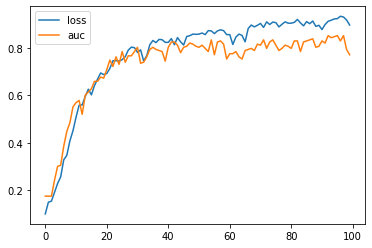

In [ ]:
loss.plot()

In [ ]:
 model = load_model("model.h5")

In [ ]:
def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  print(test_word)
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
  x = padding_doc(test_ls, max_length)
  
  pred = model.predict_proba(x)
  return pred

In [ ]:
def get_final_output(pred, classes):
  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))



# 7. Testing

In [ ]:
text = "Can you help me?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['can', 'you', 'help', 'me']
Instructions for updating:
Please use `model.predict()` instead.
commonQ.assist has confidence = 0.27475843
commonQ.name has confidence = 0.25698525
commonQ.bot has confidence = 0.12805115
commonQ.not_giving has confidence = 0.115349114
commonQ.how has confidence = 0.07079552
commonQ.query has confidence = 0.06330026
faq.bad_service has confidence = 0.057480898
contact.contact has confidence = 0.018990768
commonQ.wait has confidence = 0.0118766
faq.apply_register has confidence = 0.0020433592
faq.biz_new has confidence = 0.00013230302
commonQ.just_details has confidence = 8.3299514e-05
faq.application_process has confidence = 3.8684047e-05
faq.aadhaar_missing has confidence = 3.8386665e-05
faq.borrow_limit has confidence = 3.6693877e-05
faq.biz_simpler has confidence = 2.6483527e-05
faq.banking_option_missing has confidence = 4.680187e-06
faq.biz_category_missing has confidence = 3.7805141e-06
faq.address_proof has confidence = 2.5171287e-06
faq.borrow_use 

# 8. Save/Load Pickle

In [ ]:
# from sklearn.externals import joblib
# joblib.dump(model, 'modelnlp.pkl')

In [ ]:
# nlp_model = open('modelnlp.pkl','rb')
# nlp = joblib.load(nlp_model)

In [ ]:
# !pip install git+https://github.com/TinkerMob/keras_albert_model.git

In [ ]:
# from keras_albert_model import build_albert

# 9. Experiment with Monkeyzlearn API

In [ ]:
from monkeylearn import MonkeyLearn

ml = MonkeyLearn('e7e230d51a8668a72eea86c29559bef04bd6c8fb')
data = ["Hi Feco, looks promising, I would like to schedule a call tomorrow and see the demo. What times do you have available? Thanks, Ryan."]
model_id = 'cl_v9GTn7zi'
result = ml.classifiers.classify(model_id, data)
print(result.body)

[{'text': 'Hi Feco, looks promising, I would like to schedule a call tomorrow and see the demo. What times do you have available? Thanks, Ryan.', 'external_id': None, 'error': False, 'classifications': [{'tag_name': 'Interested', 'tag_id': 57593161, 'confidence': 1.0}]}]


In [ ]:
# !pip install monkeylearn

# 10. BERT Model

In [ ]:
!pip install bert-for-tf2


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Activation, LSTM, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bert
from tqdm import tqdm
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow_hub as hub
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)
# Params for bert model

TensorFlow Version: 2.3.0
Hub version:  0.9.0


In [ ]:
class BertModel(object):
    
    def __init__(self):
        
        self.max_len = 128
        bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
        FullTokenizer=bert.bert_tokenization.FullTokenizer
        
        self.bert_module = hub.KerasLayer(bert_path,trainable=True)

        self.vocab_file = self.bert_module.resolved_object.vocab_file.asset_path.numpy()

        self.do_lower_case = self.bert_module.resolved_object.do_lower_case.numpy()

        self.tokenizer = FullTokenizer(self.vocab_file,self.do_lower_case)
        
    def get_masks(self,tokens, max_seq_length):
        return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

    def get_segments(self,tokens, max_seq_length):
        """Segments: 0 for the first sequence, 1 for the second"""
        segments = []
        current_segment_id = 0
        for token in tokens:
            segments.append(current_segment_id)
            if token == "[SEP]":
                current_segment_id = 1
        return segments + [0] * (max_seq_length - len(tokens))
    
    def get_ids(self,tokens, tokenizer, max_seq_length):
        """Token ids from Tokenizer vocab"""
        token_ids = tokenizer.convert_tokens_to_ids(tokens,)
        input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
        return input_ids
    def create_single_input(self,sentence,maxlen):

        stokens = self.tokenizer.tokenize(sentence)

        stokens = stokens[:maxlen]

        stokens = ["[CLS]"] + stokens + ["[SEP]"]

        ids = self.get_ids(stokens, self.tokenizer, self.max_len)
        masks = self.get_masks(stokens, self.max_len)
        segments = self.get_segments(stokens, self.max_len)

        return ids,masks,segments

    def create_input_array(self,sentences):
        
        input_ids, input_masks, input_segments = [], [], []

        for sentence in tqdm(sentences,position=0, leave=True):
            ids,masks,segments=self.create_single_input(sentence,self.max_len-2)

            input_ids.append(ids)
            input_masks.append(masks)
            input_segments.append(segments)
            
        tensor = [np.asarray(input_ids, dtype=np.int32), 
                np.asarray(input_masks, dtype=np.int32), 
                np.asarray(input_segments, dtype=np.int32)]
        return tensor

In [ ]:
class PreprocessingBertData():
    
    def prepare_data_x(self,train_sentences):
        x = bert_model_obj.create_input_array(train_sentences)
        return x
    
    def prepare_data_y(self,train_labels):
        y = list()
        for item in train_labels:
            label = item
            y.append(label)
        y = np.array(y)
        return y

In [ ]:
bert_model_obj = BertModel()

In [ ]:
train_sentences = sentences

In [ ]:
output_one_hot.shape

(1113, 21)

In [ ]:
train_labels = output_one_hot.tolist()

In [ ]:
output_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
preprocess_bert_data_obj = PreprocessingBertData()
x = preprocess_bert_data_obj.prepare_data_x(train_sentences)
y = preprocess_bert_data_obj.prepare_data_y(train_labels)

train_input_ids, train_input_masks, train_segment_ids = x
train_labels = y

100%|██████████| 1113/1113 [00:00<00:00, 6532.08it/s]


In [ ]:
class DesignModel():
    def __init__(self):
        self.model = None        
        self.train_data = [train_input_ids, train_input_masks, train_segment_ids]
        self.train_labels = train_labels
        
    def bert_model(self,max_seq_length): 
        in_id = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
        in_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_masks")
        in_segment = Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
        
        bert_inputs = [in_id, in_mask, in_segment]
        pooled_output, sequence_output = bert_model_obj.bert_module(bert_inputs)
        
        x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
        x = tf.keras.layers.Dropout(0.2)(x)
        out = tf.keras.layers.Dense(21, activation="softmax", name="dense_output")(x)
        self.model = tf.keras.models.Model(inputs=bert_inputs, outputs=out)
        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")])
        
        self.model.summary()
    
    def model_train(self,batch_size,num_epoch):
        print("Fitting to model")
        
        self.model.fit(self.train_data,self.train_labels,epochs=num_epoch,batch_size=batch_size,validation_split=0.2,shuffle=True)
        
        print("Model Training complete.")

    def save_model(self,model,model_name):    
        self.model.save(model_name+".h5")
        print("Model saved to Model folder.")

In [ ]:
model_obj = DesignModel()
model_obj.bert_model(bert_model_obj.max_len)

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_ids[0][0]                  
                                                                 input_masks[0][0]    

In [ ]:
model_obj.bert_model(21)

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 21)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 21)]         0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_ids[0][0]                  
                                                                 input_masks[0][0]    

In [ ]:
# model_obj.model_train(1113, 1)